In [1]:
import numpy as np
import pandas as pd


In [40]:
path = '../res/dataset_57_hypothyroid.csv'
df = pd.read_csv(path, na_values='?')
df = df.drop(columns=['TBG', 'TBG_measured'])
df = df[~(df.age > 100)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3771 entries, 0 to 3771
Data columns (total 28 columns):
age                          3770 non-null float64
sex                          3621 non-null object
on_thyroxine                 3771 non-null object
query_on_thyroxine           3771 non-null object
on_antithyroid_medication    3771 non-null object
sick                         3771 non-null object
pregnant                     3771 non-null object
thyroid_surgery              3771 non-null object
I131_treatment               3771 non-null object
query_hypothyroid            3771 non-null object
query_hyperthyroid           3771 non-null object
lithium                      3771 non-null object
goitre                       3771 non-null object
tumor                        3771 non-null object
hypopituitary                3771 non-null object
psych                        3771 non-null object
TSH_measured                 3771 non-null object
TSH                          3402 non-null

In [41]:
df = df.drop(df[df.Class == 'secondary_hypothyroid'].index)
df = df[(df['hypopituitary'] != 't')]
df.Class.value_counts()

negative                   3479
compensated_hypothyroid     194
primary_hypothyroid          95
Name: Class, dtype: int64

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1440x360 with 0 Axes>

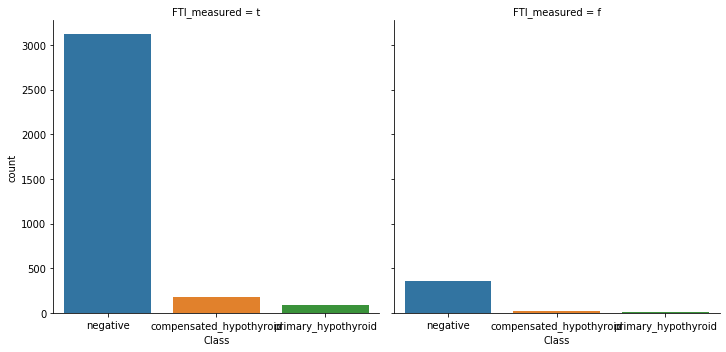

<Figure size 1440x360 with 0 Axes>

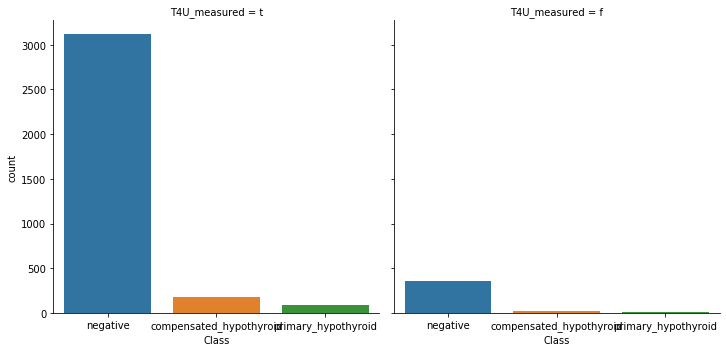

<Figure size 1440x360 with 0 Axes>

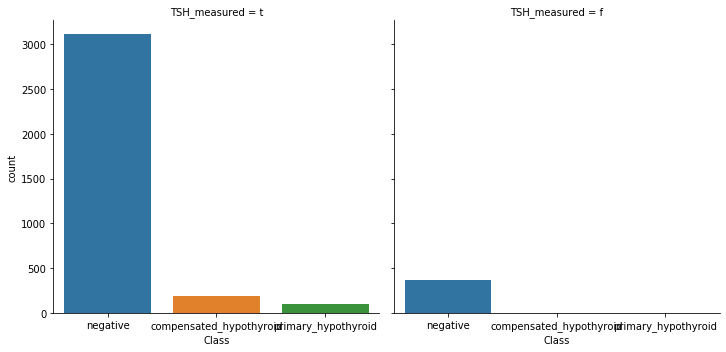

<Figure size 1440x360 with 0 Axes>

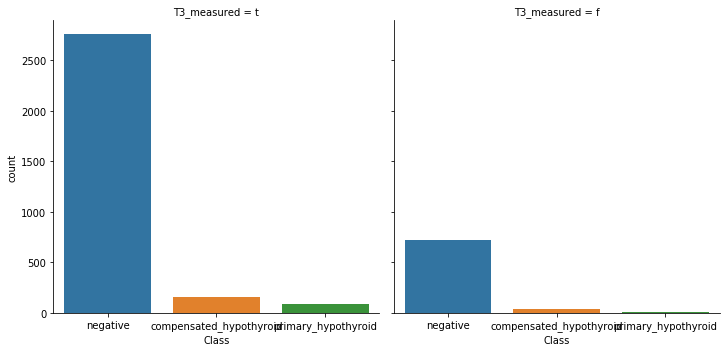

<Figure size 1440x360 with 0 Axes>

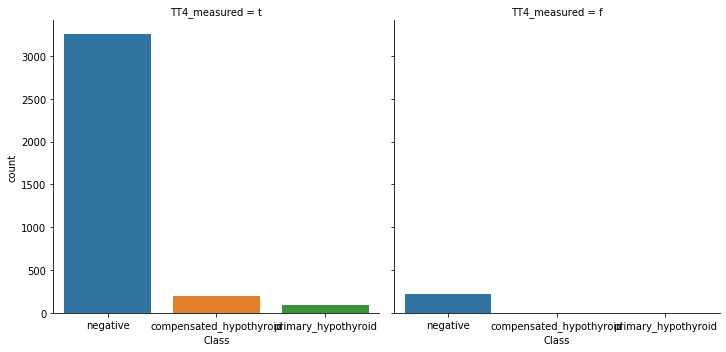

In [43]:
for i in ['FTI_measured', 'T4U_measured', 'TSH_measured', 'T3_measured', 'TT4_measured']:
    plt.figure(figsize=(20,5))
    sns.factorplot(x='Class', col=i, kind='count', data=df);

- TSH_measured, TT4_measured не влияют никак на целевую переменную

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


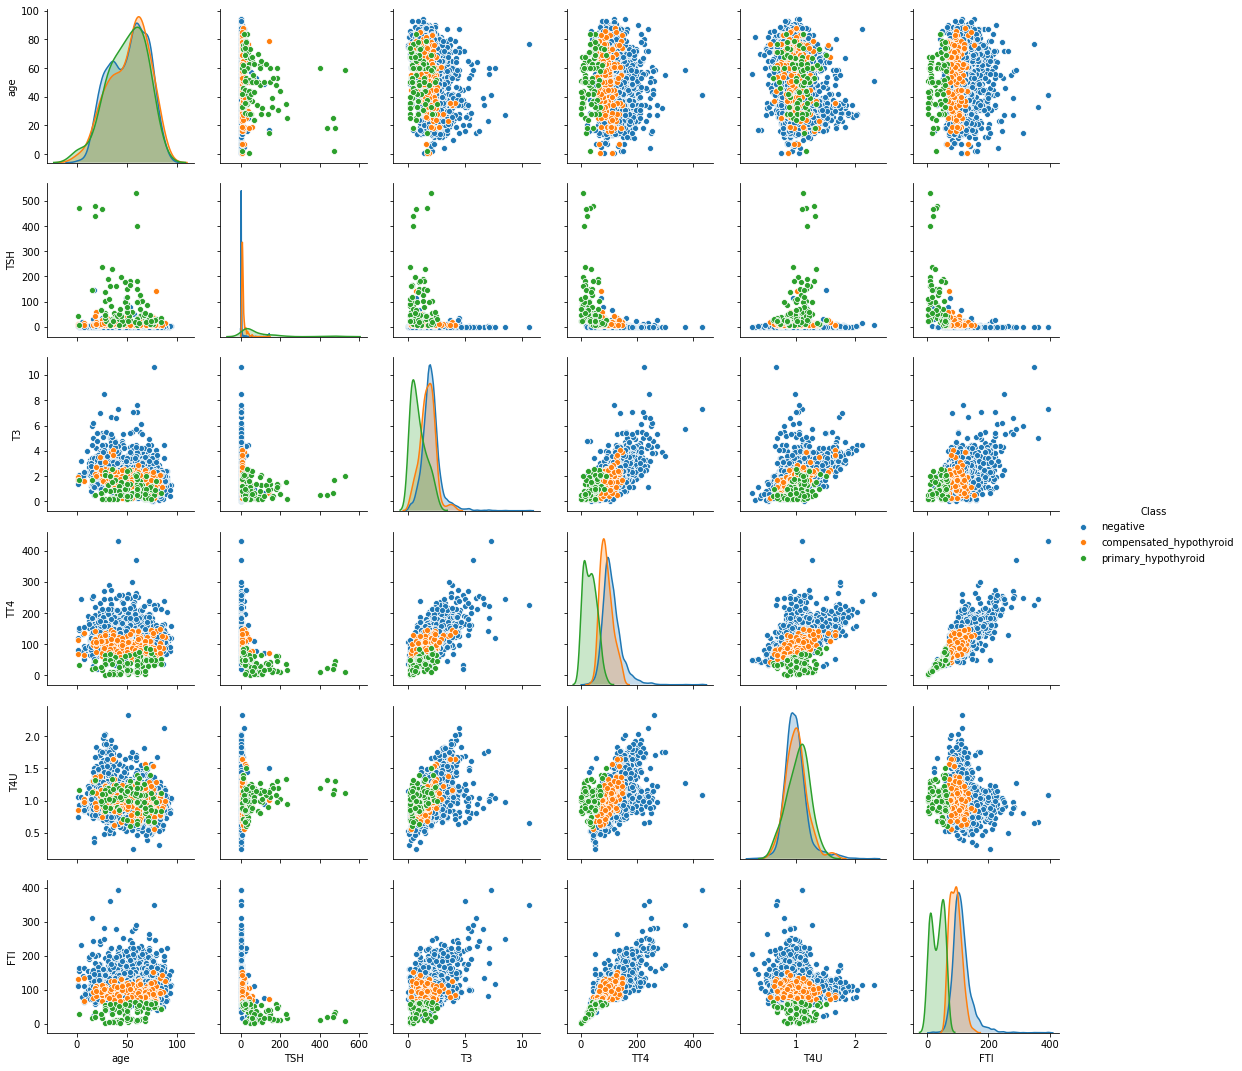

In [44]:
sns.pairplot(df, hue='Class', )

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])


num_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).drop(['Class'], axis=1).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])


pipe_lr = Pipeline(steps = [('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(multi_class = 'auto', 
                                                              solver = 'liblinear'))])


pipe_n = Pipeline(steps = [('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=2))])

In [46]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['Class'])
y = df['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify = y)

In [47]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


pipe_lr.fit(x_train, y_train)
pipe_n.fit(x_train, y_train)

scores_pipe_lr = cross_val_score(pipe_lr, x_train, y_train, cv = 5)
scores_pipe_n = cross_val_score(pipe_n, x_train, y_train, cv = 5)

print(classification_report(y_test, pipe_n.predict(x_test)))
print(scores_pipe_n)
print('\n\n')
print(classification_report(y_test, pipe_lr.predict(x_test)))
print(scores_pipe_lr)

                         precision    recall  f1-score   support

compensated_hypothyroid       0.25      0.36      0.30        58
               negative       0.96      0.94      0.95      1044
    primary_hypothyroid       0.95      0.62      0.75        29

               accuracy                           0.91      1131
              macro avg       0.72      0.64      0.67      1131
           weighted avg       0.92      0.91      0.91      1131

[0.88846881 0.90132827 0.90891841 0.90512334 0.89943074]



                         precision    recall  f1-score   support

compensated_hypothyroid       0.58      0.12      0.20        58
               negative       0.95      1.00      0.97      1044
    primary_hypothyroid       0.83      0.69      0.75        29

               accuracy                           0.94      1131
              macro avg       0.79      0.60      0.64      1131
           weighted avg       0.93      0.94      0.93      1131

[0.94517958 0.95066414 0

### under sampling

In [20]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline

under_sampling = ClusterCentroids(sampling_strategy='not minority')
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor),
                            ('under_sampling', under_sampling),
                            ('classifier', LogisticRegression(multi_class = 'auto', 
                                                              solver = 'liblinear'))])


pipe_n = Pipeline(steps = [('preprocessor', preprocessor),
                           ('under_sampling', under_sampling),
                           ('classifier', KNeighborsClassifier(n_neighbors=5))])

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


pipe_lr.fit(x_train, y_train)
pipe_n.fit(x_train, y_train)

scores_pipe_lr = cross_val_score(pipe_lr, x_train, y_train, cv = 5)
scores_pipe_n = cross_val_score(pipe_n, x_train, y_train, cv = 5)

print(classification_report(y_test, pipe_n.predict(x_test)))
print(scores_pipe_n)
print('\n\n')
print(classification_report(y_test, pipe_lr.predict(x_test)))
print(scores_pipe_lr)

                         precision    recall  f1-score   support

compensated_hypothyroid       0.10      0.79      0.19        58
               negative       0.98      0.62      0.76      1044
    primary_hypothyroid       0.68      0.72      0.70        29

               accuracy                           0.63      1131
              macro avg       0.59      0.71      0.55      1131
           weighted avg       0.93      0.63      0.73      1131

[0.51886792 0.61669829 0.5426945  0.59582543 0.51233397]



                         precision    recall  f1-score   support

compensated_hypothyroid       0.10      0.95      0.18        58
               negative       1.00      0.53      0.69      1044
    primary_hypothyroid       0.65      0.83      0.73        29

               accuracy                           0.56      1131
              macro avg       0.58      0.77      0.53      1131
           weighted avg       0.94      0.56      0.66      1131

[0.5490566  0.54079696 0

### over sampling

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

over_sampling = SMOTE(sampling_strategy='not majority')
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor),
                            ('under_sampling', over_sampling),
                            ('classifier', LogisticRegression(multi_class = 'auto', 
                                                              solver = 'liblinear'))])


pipe_n = Pipeline(steps = [('preprocessor', preprocessor),
                           ('under_sampling', over_sampling),
                           ('classifier', KNeighborsClassifier(n_neighbors=5))])

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


pipe_lr.fit(x_train, y_train)
pipe_n.fit(x_train, y_train)

scores_pipe_lr = cross_val_score(pipe_lr, x_train, y_train, cv = 5)
scores_pipe_n = cross_val_score(pipe_n, x_train, y_train, cv = 5)

print(classification_report(y_test, pipe_n.predict(x_test)))
print(scores_pipe_n)
print('\n\n')
print(classification_report(y_test, pipe_lr.predict(x_test)))
print(scores_pipe_lr)

                         precision    recall  f1-score   support

compensated_hypothyroid       0.19      0.48      0.27        58
               negative       0.97      0.89      0.92      1044
    primary_hypothyroid       0.72      0.72      0.72        29

               accuracy                           0.86      1131
              macro avg       0.63      0.70      0.64      1131
           weighted avg       0.92      0.86      0.89      1131

[0.83584906 0.84440228 0.85578748 0.86527514 0.83491461]



                         precision    recall  f1-score   support

compensated_hypothyroid       0.67      0.91      0.77        58
               negative       1.00      0.97      0.98      1044
    primary_hypothyroid       0.69      0.86      0.77        29

               accuracy                           0.96      1131
              macro avg       0.79      0.92      0.84      1131
           weighted avg       0.97      0.96      0.97      1131

[0.9509434  0.93927894 0

### Feature engineering

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('features', PolynomialFeatures(degree = 2)),
    ('scaler', StandardScaler()),

])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])


num_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).drop(['Class'], axis=1).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])



over_sampling = SMOTE(sampling_strategy='not majority')

pipe_lr = Pipeline(steps = [('preprocessor', preprocessor),
                            ('over_sampling', over_sampling),
                            ('classifier', LogisticRegression(multi_class = 'auto', 
                                                              solver = 'liblinear'))])


pipe_n = Pipeline(steps = [('preprocessor', preprocessor),
                           ('over_sampling', over_sampling),
                           ('classifier', KNeighborsClassifier(n_neighbors=3))])





pipe_lr.fit(x_train, y_train)
pipe_n.fit(x_train, y_train)

scores_pipe_lr = cross_val_score(pipe_lr, x_train, y_train, cv = 5)
scores_pipe_n = cross_val_score(pipe_n, x_train, y_train, cv = 5)

print(classification_report(y_test, pipe_n.predict(x_test)))
print(scores_pipe_n)
print('\n\n')
print(classification_report(y_test, pipe_lr.predict(x_test)))
print(scores_pipe_lr)

                         precision    recall  f1-score   support

compensated_hypothyroid       0.51      0.74      0.60        58
               negative       0.99      0.96      0.97      1044
    primary_hypothyroid       0.80      0.69      0.74        29

               accuracy                           0.95      1131
              macro avg       0.76      0.80      0.77      1131
           weighted avg       0.96      0.95      0.95      1131

[0.95085066 0.93548387 0.94686907 0.9373814  0.94686907]



                         precision    recall  f1-score   support

compensated_hypothyroid       0.64      0.97      0.77        58
               negative       1.00      0.97      0.98      1044
    primary_hypothyroid       0.65      0.69      0.67        29

               accuracy                           0.96      1131
              macro avg       0.76      0.87      0.81      1131
           weighted avg       0.97      0.96      0.96      1131

[0.97353497 0.97533207 0

### Feature importance and hyperparameters tuning

In [62]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



param_grid = {
    'classifier__C': np.logspace(-4, 4, 4),
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__penalty': ["l1","l2"],

    
}
search = GridSearchCV(pipe_lr, param_grid)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)






/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Best parameter (CV score=0.980):
{'classifier__C': 10000.0, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [63]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


pipe_n.get_params().keys()
param_grid = {
    'classifier__n_neighbors': [x for x in range(1, 10)],
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__weights': ["uniform","distance"]   
}


search = GridSearchCV(pipe_n, param_grid, cv = 5)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.909):
{'classifier__n_neighbors': 2, 'classifier__weights': 'distance', 'preprocessor__num__imputer__strategy': 'median'}


### Лучше всего себя показала модель LogisticRegression 

In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline


pipe_lr = Pipeline(steps = [('preprocessor', preprocessor),
                            ('over_sampling', over_sampling),
                            ('classifier', LogisticRegression(multi_class = 'auto', 
                                                              solver = 'liblinear',
                                                             C =  10000.0, penalty =  'l2', max_iter = 10**5))])

pipe_lr.fit(x_train, y_train)
pipe_n.fit(x_train, y_train)


scores_pipe_lr = cross_val_score(pipe_lr, x_train, y_train, cv = 5)


print(classification_report(y_test, pipe_lr.predict(x_test)))
print(scores_pipe_lr)

                         precision    recall  f1-score   support

compensated_hypothyroid       0.75      0.91      0.82        58
               negative       0.99      0.98      0.99      1044
    primary_hypothyroid       0.69      0.76      0.72        29

               accuracy                           0.97      1131
              macro avg       0.81      0.88      0.84      1131
           weighted avg       0.97      0.97      0.97      1131

[0.97542533 0.9772296  0.96774194 0.98102467 0.97343454]
